# Kaggle Project: Dog Breed Identification (Playground)

[Project Page](https://www.kaggle.com/c/dog-breed-identification/data) 

In this playground competition, you are provided a strictly canine subset of ImageNet in order to practice fine-grained image categorization. How well you can tell your Norfolk Terriers from your Norwich Terriers? With 120 breeds of dogs and a limited number training images per class, you might find the problem more, err, ruff than you anticipated.

## File descriptions


* train.zip - the training set, you are provided the breed for these dogs
* test.zip - the test set, you must predict the probability of each breed for each image
* sample_submission.csv - a sample submission file in the correct format
* labels.csv - the breeds for the images in the train set

## Submission File

or each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:

```
id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.
```


In [1]:
import math
from glob import glob
import os
import random
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
import scipy

from sklearn.model_selection import train_test_split

%matplotlib inline



# Import Keras
import keras
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


# Preview data labels and train/ test images

In [4]:
# Read train label data
train_labels = pd.read_csv("./input/labels.csv")
print("Number of training examples:{}".format(len(train_labels)))
train_labels.head()

Number of training examples:10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [18]:
# Turn train_lables to a dic
train_labels_dict = train_labels.set_index('id')['breed'].to_dict()

In [15]:
# List all the breeds
all_breeds = ['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',
 'ibizan_hound',
 'irish_setter',
 'irish_terrier',
 'irish_water_spaniel',
 'irish_wolfhound',
 'italian_greyhound',
 'japanese_spaniel',
 'keeshond',
 'kelpie',
 'kerry_blue_terrier',
 'komondor',
 'kuvasz',
 'labrador_retriever',
 'lakeland_terrier',
 'leonberg',
 'lhasa',
 'malamute',
 'malinois',
 'maltese_dog',
 'mexican_hairless',
 'miniature_pinscher',
 'miniature_poodle',
 'miniature_schnauzer',
 'newfoundland',
 'norfolk_terrier',
 'norwegian_elkhound',
 'norwich_terrier',
 'old_english_sheepdog',
 'otterhound',
 'papillon',
 'pekinese',
 'pembroke',
 'pomeranian',
 'pug',
 'redbone',
 'rhodesian_ridgeback',
 'rottweiler',
 'saint_bernard',
 'saluki',
 'samoyed',
 'schipperke',
 'scotch_terrier',
 'scottish_deerhound',
 'sealyham_terrier',
 'shetland_sheepdog',
 'shih-tzu',
 'siberian_husky',
 'silky_terrier',
 'soft-coated_wheaten_terrier',
 'staffordshire_bullterrier',
 'standard_poodle',
 'standard_schnauzer',
 'sussex_spaniel',
 'tibetan_mastiff',
 'tibetan_terrier',
 'toy_poodle',
 'toy_terrier',
 'vizsla',
 'walker_hound',
 'weimaraner',
 'welsh_springer_spaniel',
 'west_highland_white_terrier',
 'whippet',
 'wire-haired_fox_terrier',
 'yorkshire_terrier']

num_breeds = len(all_breeds)
print("Number of Breeds: {}".format(num_breeds))

Number of Breeds: 120


In [16]:
# Set file directories
TRAIN_DIR = './input/train/'
TEST_DIR = './input/test/'
train_file_paths = [(os.path.splitext(os.path.basename(filename))[0], os.path.join(TRAIN_DIR, filename)) 
                    for filename in os.listdir(TRAIN_DIR)]

test_file_paths = [(os.path.splitext(os.path.basename(filename))[0], os.path.join(TEST_DIR, filename)) 
                    for filename in os.listdir(TEST_DIR)]


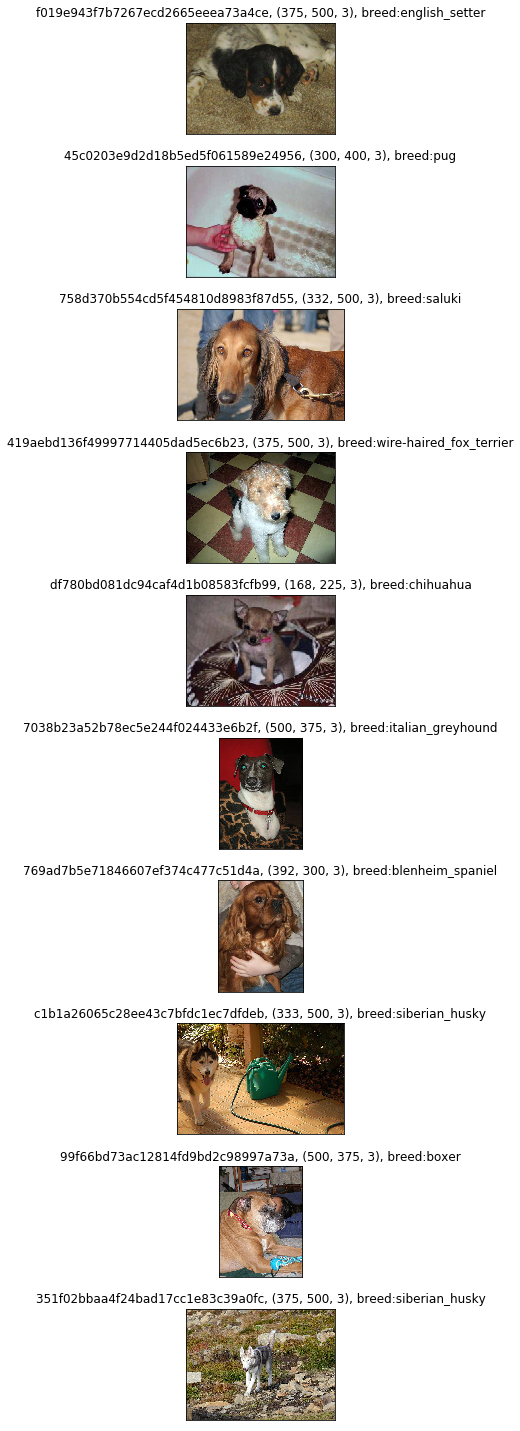

In [19]:
# Preview train images

fig, axes = plt.subplots(figsize=(20, 20), nrows=10, ncols=1)
plt.tight_layout() # Increases space between subplots

# Randomly select and display images
for ax in axes.flat:
    file_id, file_path = random.choice(train_file_paths)
    img=mpimg.imread(file_path)
    ax.imshow(img)
    ax.set_title("{}, {}, breed:{}".format(file_id, img.shape, train_labels_dict[file_id]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

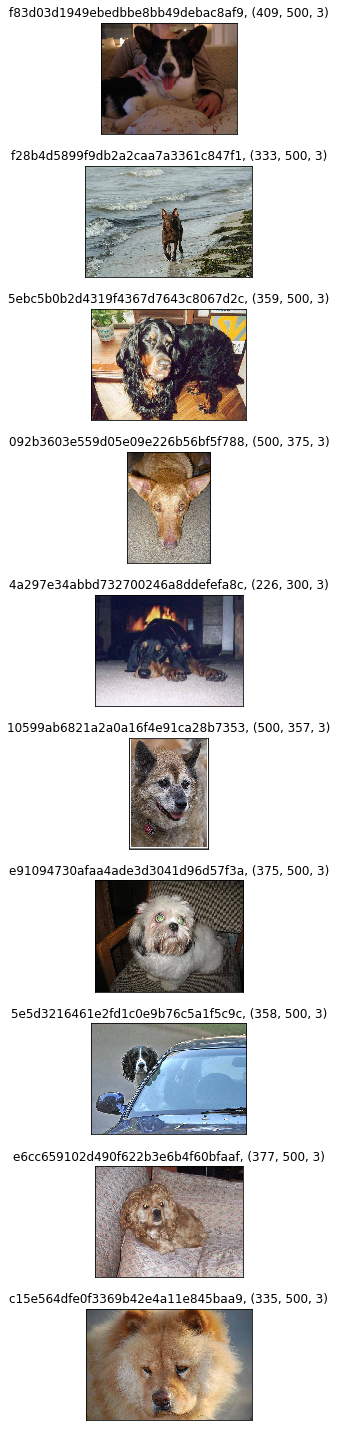

In [20]:
# Preview test images

fig, axes = plt.subplots(figsize=(20, 20), nrows=10, ncols=1)
plt.tight_layout() # Increases space between subplots

# Randomly select and display images
for ax in axes.flat:
    file_id, file_path = random.choice(test_file_paths)
    img=mpimg.imread(file_path)
    ax.imshow(img)
    ax.set_title("{}, {}".format(file_id, img.shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Prepare Data for Supervised Learning Task

## Steps

1. Split train data into train and validation sets
2. Copy train and validation images into directories so we can use Keras' ImageDataGenerator.flow_from_directory
3. Convert samples' breed info into numeric labels and one-hot encode them
4. Set up Image DataGenerator for test and validation sets

In [21]:
# Split train data into train and validation

X_train, X_val, y_train, y_val = train_test_split(train_labels['id'], 
                                                    train_labels['breed'], 
                                                    test_size=0.2, 
                                                    stratify=train_labels['breed'])

In [22]:
# Verify that we have all 120 breeds in both train and validation sets
print(len(y_train.unique()))
print(len(y_val.unique()))

120
120


In [23]:
# Make the temp directories to store the images for train and test sets
import shutil
import os

TRAIN_TEMP_BASEDIR = './input/temp/train'
VALID_TEMP_BASEDIR = './input/temp/valid'

# Make sub-directory for each breed under TRAIN_TEMP_BASEDIR
for breed in all_breeds:
    os.makedirs(os.path.join(TRAIN_TEMP_BASEDIR, breed))
# Make sub-directory for each breed under TRAIN_TEMP_BASEDIR
for breed in all_breeds:
    os.makedirs(os.path.join(VALID_TEMP_BASEDIR, breed))

In [24]:
# Copy train files to destination based on breed

for index, file_id in X_train.iteritems():
    breed = y_train[index]
    src = os.path.join(TRAIN_DIR, "{}.jpg".format(file_id))
    dst = os.path.join(TRAIN_TEMP_BASEDIR, breed)
    shutil.copy2(src, dst)

In [25]:
# Copy valid files to destination based on breed

for index, file_id in X_val.iteritems():
    breed = y_val[index]
    src = os.path.join(TRAIN_DIR, "{}.jpg".format(file_id))
    dst = os.path.join(VALID_TEMP_BASEDIR, breed)
    shutil.copy2(src, dst)

# Set up Keras model and image generator

In [43]:
# Set up ResNet as base model
base_model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(244, 244,3))

# Freeze the base model's layers from training
for layer in base_model.layers:
    layer.trainable = False

# Add a new top layer
x = base_model.output
x = Flatten()(x)
predictions = Dense(num_breeds, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])





model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 244, 244, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 122, 122, 64)  9472        input_6[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 122, 122, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_246 (Activation)      (None, 122, 122, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [44]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32 
train_generator = train_datagen.flow_from_directory(
        directory=TRAIN_TEMP_BASEDIR,
        target_size=(244, 244),
        batch_size=batch_size,
        classes=all_breeds)

val_generator = test_datagen.flow_from_directory(
        directory=VALID_TEMP_BASEDIR,
        target_size=(244, 244),
        batch_size=batch_size,
        classes=all_breeds)

Found 8177 images belonging to 120 classes.
Found 2045 images belonging to 120 classes.


In [45]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 3, verbose = 1),
    keras.callbacks.TensorBoard(log_dir='./logs'),
    keras.callbacks.ModelCheckpoint('./checkpoints/{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', 
                                    verbose=0,save_best_only=True, mode='auto', period=1)
]


model.fit_generator(
        train_generator,
        steps_per_epoch=len(X_train) // batch_size ,
        epochs=50,
        validation_data=val_generator,
        validation_steps=len(X_val) // batch_size,
        callbacks=callbacks_list
)

Epoch 1/50
255/255 [==============================] - 104s - loss: 2.8284 - acc: 0.3350 - val_loss: 6.7091 - val_acc: 0.0084
Epoch 2/50
255/255 [==============================] - 92s - loss: 1.4183 - acc: 0.6115 - val_loss: 6.9155 - val_acc: 0.0179
Epoch 3/50
255/255 [==============================] - 93s - loss: 1.0570 - acc: 0.6996 - val_loss: 5.2905 - val_acc: 0.1580
Epoch 4/50
255/255 [==============================] - 94s - loss: 0.8721 - acc: 0.7512 - val_loss: 2.1457 - val_acc: 0.4868
Epoch 5/50
255/255 [==============================] - 94s - loss: 0.7210 - acc: 0.7901 - val_loss: 1.4199 - val_acc: 0.6244
Epoch 6/50
255/255 [==============================] - 93s - loss: 0.6297 - acc: 0.8133 - val_loss: 1.4784 - val_acc: 0.6041
Epoch 7/50
255/255 [==============================] - 93s - loss: 0.5506 - acc: 0.8415 - val_loss: 1.4732 - val_acc: 0.6165
Epoch 8/50
255/255 [==============================] - 93s - loss: 0.4933 - acc: 0.8543 - val_loss: 1.5412 - val_acc: 0.6046
Epoch 9